# Импорты

Импорт всех необходимых библиотек

In [2]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [6]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [7]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [8]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

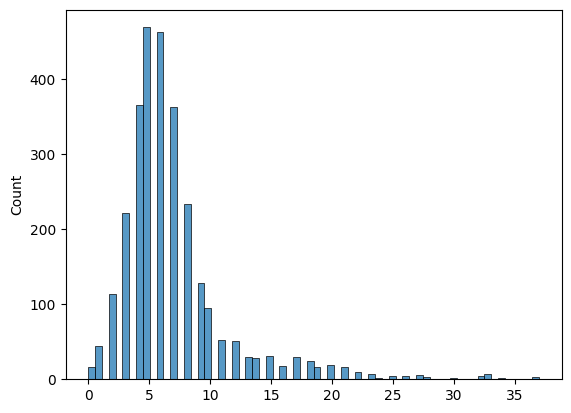

In [9]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [10]:
df = df.drop(df[df['bmi']>80].index)

In [11]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

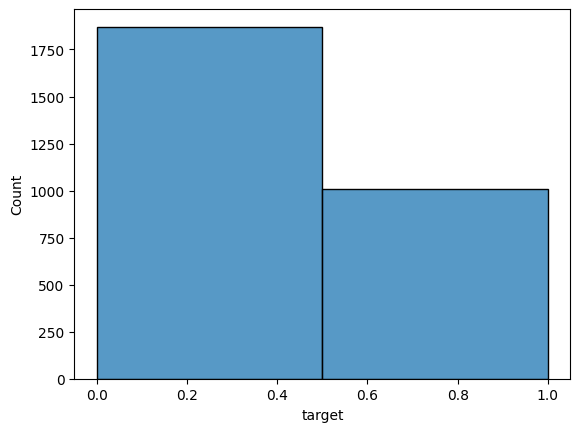

In [12]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [13]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

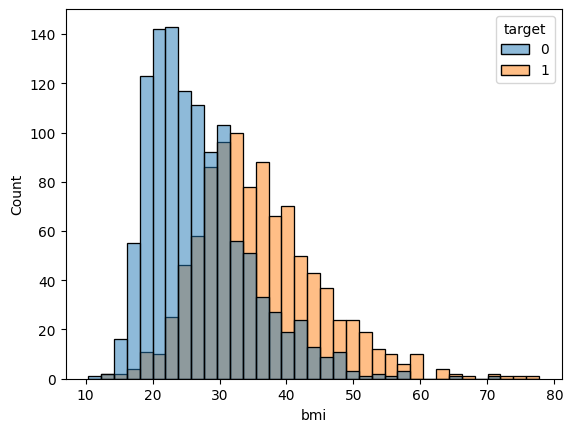

In [14]:
sns.histplot(data=df, x='bmi', hue='target')

In [15]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])

In [16]:
df_temp = df.drop(df_test.index)
x_temp = df_temp.drop(columns=['target'])
y_temp = df_temp['target']
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [17]:
column_names = x_train.columns

In [18]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_val = pd.DataFrame(scaler.transform(x_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [19]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [20]:
x_train = x_train.rename(columns=column_dict)
x_val = x_val.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,-0.428150,-0.615153,-0.676507,-0.574648,-0.633920,-0.496056,-0.477496,-0.525250,-0.458051,-0.090633,-0.189512,-0.575997,-0.527770,-0.565793,-0.427402,-0.223213,-0.651220,-0.324592,-0.339509,-0.161661,-0.230115,-0.139510,-0.630714,-0.528592,-0.495578,-0.576073,-0.281690,-0.521308,-0.585340,-0.245922,-0.544060,-0.467350,-0.674085,-0.716631,-0.681828,NaN,-0.197702,-0.521448,-0.649625,-0.242034,-0.115091,-0.589197,-0.379930,-0.222982,-0.159506,-0.154782,-0.178905,-0.219458,-0.225360,-0.458997,NaN,-0.226630,-0.158384,NaN,-0.176734,-0.540834,-0.573435,-0.382748,-0.086247,-0.525080,-0.393294,-0.202713,-0.303238,-0.181608,-0.211920,-0.258890,-0.351586,1.095831,-0.280636,-0.466416,1.485938,0.108947
1,-0.304325,-0.862446,-0.313480,-0.440521,-0.619781,-0.053881,-0.345221,-0.493243,-0.521276,-0.230015,-0.382717,-0.355587,-0.377114,-0.369351,-0.314391,-0.537303,-0.375503,-0.401786,-0.379851,-0.603931,-0.221216,NaN,-0.187345,-0.120682,-0.368504,-0.304802,-0.349998,-0.191309,-0.193280,-0.297249,-0.073681,-0.171124,-0.333624,-0.423654,-0.067431,-0.379809,-0.450088,-0.246472,-0.136328,-0.359439,-0.303859,-0.451859,NaN,-0.375205,-0.186582,-0.303340,-0.374638,-0.319374,-0.300400,-0.401613,-0.198171,-0.358928,-0.498816,-0.250539,-0.306624,-0.111302,-0.243519,-0.314227,-0.287213,0.614006,0.147514,-0.458641,0.744259,-0.260802,-0.374096,-0.226902,0.015583,-0.333935,-0.394846,-0.423532,-0.912549,-0.280636,-0.466416,-0.672975,-0.416080
2,NaN,-0.478777,-0.005276,0.788102,1.104932,0.074272,0.061726,0.506036,-0.337786,-0.272056,0.690924,0.377865,0.839588,0.823729,-0.125453,0.462641,-0.249152,0.226037,0.985143,1.315228,-0.184403,-0.189683,-0.093172,0.000478,0.781444,-0.068176,0.690713,-0.042398,-0.556805,-0.002881,0.066203,0.220080,-0.160800,-0.137690,-0.322793,-0.085532,0.503218,-0.346907,-0.293372,0.807381,0.226888,-0.102471,-0.212287,0.862581,-0.098236,0.581805,-0.071326,0.817467,-0.299738,0.839187,0.121143,0.862259,0.487724,NaN,0.807962,-0.202327,2.144660,0.839512,0.344005,-0.570849,0.067952,-0.385182,-0.539162,-0.198453,-0.968618,-0.781305,0.541425,-0.165129,-0.809911,0.150814,1.095831,-0.280636,-0.466416,1.485938,-0.576229
3,NaN,NaN,NaN,0.387739,-0.001168,-0.292018,-0.763337,1.292026,5.467698,-0.403382,-0.215609,0.357804,0.360996,0.367551,0.446715,-0.460036,0.279119,-0.257748,0.403342,-0.162205,0.470842,9.169579,NaN,-0.245534,0.432975,0.515202,-0.216498,0.964242,-0.626170,0.638687,0.297011,1.293974,0.760070,2.232801,1.316609,-0.041704,4.322932,NaN,NaN,0.359715,0.916579,-0.320014,NaN,0.449986,-0.253347,-0.251119,NaN,0.450362,-0.297984,0.441495,0.033332,0.327990,-0.565377,0.398956,0.322664,-0.176768,NaN,0.397146,2.195154,0.481420,-0.101786,-0.086247,0.295665,0.082119,-0.247627,-0.358075,0.948298,26.334392,-0.170119,0.184958,-0.912549,-0.280636,-0.466416,-0.672975,NaN
4,NaN,NaN,NaN,0.384922,0.428468,0.531438,-0.040170,0.323594,0.590310,0.329961,-0.085636,0.276018,0.607033,0.639503,0.489552,0.453109,0.194897,-0.117516,0.559981,0.468267,0.387985,-0.321188,-0.183064,-0.015491,0.666947,0.175777,-0.092491,0.211204,0.217131,1.478902,0.317993,0.273775,0.386047,0.268680,0.657665,-0.045878,0.405272,1.183690,NaN,0.584992

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [21]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean')#IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_val_imp = it_imp.transform(x_val)
x_test_imp = it_imp.transform(x_test)

In [22]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [23]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-24 10:37:11,645] A new study created in memory with name: no-name-da7d6350-6cb2-49d7-aeec-634654e62678
[I 2024-11-24 10:37:13,698] Trial 0 finished with value: 0.401294498381877 and parameters: {'max_depth': 5, 'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.401294498381877.
[I 2024-11-24 10:37:22,118] Trial 1 finished with value: 0.4539877300613497 and parameters: {'max_depth': 8, 'n_estimators': 900, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4539877300613497.
[I 2024-11-24 10:37:31,515] Trial 2 finished with value: 0.45731707317073167 and parameters: {'max_depth': 10, 'n_estimators': 900, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.45731707317073167.
[I 2024-11-24 10:37:38,948] Trial 3 finished with value: 0.4375 and parameters: {'max_depth': 8, 'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.457317073

In [24]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best ROC-AUC score: 0.48338368580060426


In [25]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10)

Метрики, получаемые из кросс-валидации

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.8307991 , 0.83090925, 0.82767463, 0.81151891, 0.82232451]),
 'score_time': array([0.03869367, 0.0277524 , 0.02698851, 0.027879  , 0.02697659]),
 'test_accuracy': array([0.78896882, 0.80815348, 0.78846154, 0.80288462, 0.83173077]),
 'test_precision_macro': array([0.76722311, 0.79225099, 0.76420356, 0.78051416, 0.81600501]),
 'test_recall_macro': array([0.73661366, 0.75520724, 0.73886555, 0.75903361, 0.79180672]),
 'test_f1_macro': array([0.74749532, 0.76826896, 0.74839863, 0.76764842, 0.80165109]),
 'test_roc_auc': array([0.86347758, 0.87811388, 0.8572479 , 0.85301996, 0.88109244])}

In [27]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [28]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [29]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [30]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67       216
           1       0.67      0.35      0.46       216

    accuracy                           0.59       432
   macro avg       0.62      0.59      0.57       432
weighted avg       0.62      0.59      0.57       432

F2-score:  0.38894575230296835


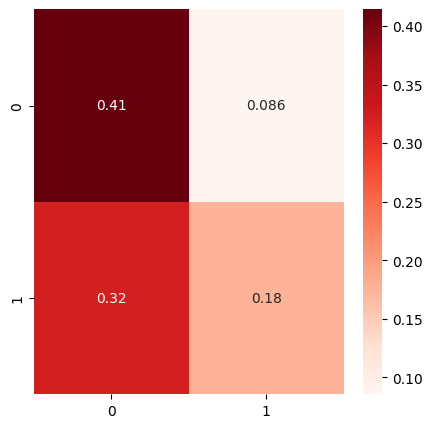

In [31]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [32]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [33]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-24 10:39:25,686] A new study created in memory with name: no-name-164dc89d-7963-4c31-beae-8b19a3195f12


[10:39:25] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:26,464] Trial 0 finished with value: 0.6338329764453962 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 0 with value: 0.6338329764453962.


[10:39:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:34,690] Trial 1 finished with value: 0.6161137440758294 and parameters: {'max_depth': 7, 'n_estimators': 1000}. Best is trial 0 with value: 0.6338329764453962.


[10:39:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:38,005] Trial 2 finished with value: 0.6261682242990654 and parameters: {'max_depth': 7, 'n_estimators': 400}. Best is trial 0 with value: 0.6338329764453962.


[10:39:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:43,609] Trial 3 finished with value: 0.6214953271028036 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 0 with value: 0.6338329764453962.


[10:39:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:44,917] Trial 4 finished with value: 0.632258064516129 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 0 with value: 0.6338329764453962.


[10:39:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:46,000] Trial 5 finished with value: 0.6182669789227166 and parameters: {'max_depth': 9, 'n_estimators': 100}. Best is trial 0 with value: 0.6338329764453962.


[10:39:46] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:49,815] Trial 6 finished with value: 0.6276346604215456 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 0 with value: 0.6338329764453962.


[10:39:49] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:52,733] Trial 7 finished with value: 0.6293103448275862 and parameters: {'max_depth': 3, 'n_estimators': 900}. Best is trial 0 with value: 0.6338329764453962.


[10:39:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:39:57,272] Trial 8 finished with value: 0.6179245283018867 and parameters: {'max_depth': 10, 'n_estimators': 400}. Best is trial 0 with value: 0.6338329764453962.


[10:39:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:00,124] Trial 9 finished with value: 0.6175115207373272 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 0 with value: 0.6338329764453962.


[10:40:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:00,724] Trial 10 finished with value: 0.6178489702517163 and parameters: {'max_depth': 5, 'n_estimators': 100}. Best is trial 0 with value: 0.6338329764453962.


[10:40:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:01,409] Trial 11 finished with value: 0.6338329764453962 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 0 with value: 0.6338329764453962.


[10:40:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:02,337] Trial 12 finished with value: 0.6325167037861916 and parameters: {'max_depth': 4, 'n_estimators': 200}. Best is trial 0 with value: 0.6338329764453962.


[10:40:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:04,633] Trial 13 finished with value: 0.630669546436285 and parameters: {'max_depth': 3, 'n_estimators': 700}. Best is trial 0 with value: 0.6338329764453962.


[10:40:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:05,550] Trial 14 finished with value: 0.6325167037861916 and parameters: {'max_depth': 4, 'n_estimators': 200}. Best is trial 0 with value: 0.6338329764453962.


[10:40:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:06,709] Trial 15 finished with value: 0.6210045662100455 and parameters: {'max_depth': 5, 'n_estimators': 200}. Best is trial 0 with value: 0.6338329764453962.


[10:40:06] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:09,379] Trial 16 finished with value: 0.6320541760722347 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 0 with value: 0.6338329764453962.


[10:40:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:11,501] Trial 17 finished with value: 0.627906976744186 and parameters: {'max_depth': 6, 'n_estimators': 300}. Best is trial 0 with value: 0.6338329764453962.


[10:40:11] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:13,443] Trial 18 finished with value: 0.6263498920086393 and parameters: {'max_depth': 3, 'n_estimators': 600}. Best is trial 0 with value: 0.6338329764453962.


[10:40:13] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:14,798] Trial 19 finished with value: 0.6353467561521253 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:16,152] Trial 20 finished with value: 0.6353467561521253 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:17,510] Trial 21 finished with value: 0.6353467561521253 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:17] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:18,863] Trial 22 finished with value: 0.6353467561521253 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:21,721] Trial 23 finished with value: 0.6175115207373272 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 19 with value: 0.6353467561521253.


[10:40:21] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:23,847] Trial 24 finished with value: 0.627906976744186 and parameters: {'max_depth': 6, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:25,196] Trial 25 finished with value: 0.6353467561521253 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:25] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:28,052] Trial 26 finished with value: 0.6175115207373272 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 19 with value: 0.6353467561521253.


[10:40:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:28,524] Trial 27 finished with value: 0.6210045662100455 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 19 with value: 0.6353467561521253.


[10:40:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:30,636] Trial 28 finished with value: 0.627906976744186 and parameters: {'max_depth': 6, 'n_estimators': 300}. Best is trial 19 with value: 0.6353467561521253.


[10:40:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 10:40:32,965] Trial 29 finished with value: 0.6189376443418013 and parameters: {'max_depth': 5, 'n_estimators': 400}. Best is trial 19 with value: 0.6353467561521253.


In [34]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 300}
Best f1 score: 0.6353467561521253


In [35]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train, y_train)

[10:40:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=300, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [36]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())

[10:40:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:40:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:40:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:40:37] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[10:40:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [37]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       216
           1       0.61      0.66      0.64       216

    accuracy                           0.62       432
   macro avg       0.62      0.62      0.62       432
weighted avg       0.62      0.62      0.62       432

F2-score:  0.6484018264840183


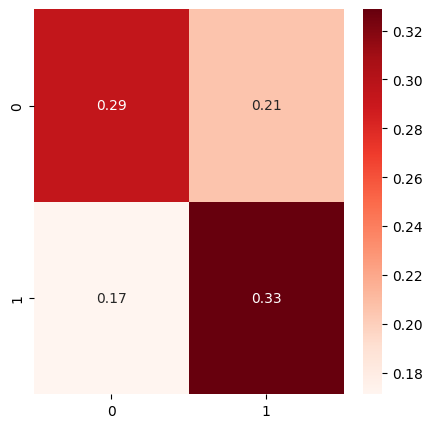

In [38]:
report(y_test, xgb_rfc_best.predict(x_test))

## Бустинги

### Catboost

In [39]:
model = CatBoostClassifier(random_seed=42)

In [40]:
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.037982
0:	learn: 0.6691266	test: 0.6878497	best: 0.6878497 (0)	total: 57.9ms	remaining: 57.9s
200:	learn: 0.2349513	test: 0.6425406	best: 0.6420754 (198)	total: 904ms	remaining: 3.59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6420754362
bestIteration = 198

Shrink model to first 199 iterations.


In [41]:
f1_score(y_test, model.predict(x_test))

0.6265060240963856

In [42]:
model.get_feature_importance(catboost.Pool(x_train))

array([ 0.88353736,  3.08033999,  0.81529795,  1.85462434,  1.02698258,
        0.76064659,  1.77749133,  0.45122158,  0.99035141,  0.72096888,
        0.75053863,  0.6641428 ,  0.39115258,  0.74641805,  0.6011909 ,
        1.10536985,  0.41784548,  1.41889887,  1.05136805,  1.0605325 ,
        0.65910745,  1.37346501,  0.77693023,  0.70014802,  0.36482208,
        0.68892091,  0.60588945,  0.63528136,  1.87029064,  1.15522695,
        0.80174677,  0.70493659,  0.53873527,  0.51908455,  0.57575437,
        1.25922444,  1.56515953,  2.70007323,  1.70098416,  0.4942582 ,
        0.55328611,  1.4159866 ,  1.63074699,  0.92470508,  0.936881  ,
        1.60784071,  1.80868806,  0.50459006,  1.00916135,  0.37108337,
        0.53355032,  0.17659676,  0.91463115,  0.42463342,  0.52522191,
        1.03568317,  0.69656504,  1.1593388 ,  0.20827258,  1.25515203,
        1.10010237,  0.34736463,  2.18945767,  0.54518159,  1.01626379,
        0.93308695,  1.4564248 ,  0.60421959,  0.66132463,  0.30

In [43]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [44]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-24 10:40:41,673] A new study created in memory with name: no-name-a0dbd0fe-fc31-4af1-8b40-30cefd1844c9
[I 2024-11-24 10:40:56,984] Trial 0 finished with value: 0.618705035971223 and parameters: {'learning_rate': 0.01044793767211954, 'depth': 8, 'subsample': 0.13619113175973546, 'colsample_bylevel': 0.7507539457542411, 'min_data_in_leaf': 76, 'random_strength': 0.7895264057685654}. Best is trial 0 with value: 0.618705035971223.
[I 2024-11-24 10:40:59,323] Trial 1 finished with value: 0.630071599045346 and parameters: {'learning_rate': 0.006222940469063291, 'depth': 6, 'subsample': 0.8523881482522764, 'colsample_bylevel': 0.14479132267679423, 'min_data_in_leaf': 7, 'random_strength': 1.82329919355377}. Best is trial 1 with value: 0.630071599045346.
[I 2024-11-24 10:41:03,032] Trial 2 finished with value: 0.6103286384976526 and parameters: {'learning_rate': 0.0018262469291235677, 'depth': 7, 'subsample': 0.9828021846349766, 'colsample_bylevel': 0.1730393017296245, 'min_data_in_

In [45]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.013272728600603374, 'depth': 8, 'subsample': 0.9339107325505326, 'colsample_bylevel': 0.3238199972103882, 'min_data_in_leaf': 87, 'random_strength': 1.353214541281198}
Best f1 score: 0.6490384615384616


In [46]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train, y_train)

0:	learn: 0.6829780	total: 7.71ms	remaining: 7.7s
1:	learn: 0.6735580	total: 15.8ms	remaining: 7.86s
2:	learn: 0.6647577	total: 27ms	remaining: 8.97s
3:	learn: 0.6556490	total: 35.9ms	remaining: 8.93s
4:	learn: 0.6468158	total: 43.4ms	remaining: 8.63s
5:	learn: 0.6391932	total: 53.3ms	remaining: 8.84s
6:	learn: 0.6311812	total: 61.4ms	remaining: 8.71s
7:	learn: 0.6244123	total: 71.4ms	remaining: 8.86s
8:	learn: 0.6203342	total: 79.8ms	remaining: 8.79s
9:	learn: 0.6117432	total: 86.8ms	remaining: 8.59s
10:	learn: 0.6057636	total: 96ms	remaining: 8.63s
11:	learn: 0.5980231	total: 103ms	remaining: 8.49s
12:	learn: 0.5911892	total: 113ms	remaining: 8.61s
13:	learn: 0.5846829	total: 124ms	remaining: 8.7s
14:	learn: 0.5790514	total: 132ms	remaining: 8.68s
15:	learn: 0.5730587	total: 140ms	remaining: 8.59s
16:	learn: 0.5663599	total: 149ms	remaining: 8.63s
17:	learn: 0.5602787	total: 157ms	remaining: 8.56s
18:	learn: 0.5544365	total: 167ms	remaining: 8.61s
19:	learn: 0.5497652	total: 176ms	re

In [47]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6827968	total: 7.35ms	remaining: 7.34s
1:	learn: 0.6731033	total: 15.1ms	remaining: 7.53s
2:	learn: 0.6643725	total: 26.9ms	remaining: 8.94s
3:	learn: 0.6551101	total: 36.5ms	remaining: 9.08s
4:	learn: 0.6467933	total: 43.8ms	remaining: 8.71s
5:	learn: 0.6391715	total: 53.2ms	remaining: 8.81s
6:	learn: 0.6312054	total: 60.7ms	remaining: 8.62s
7:	learn: 0.6241291	total: 71.4ms	remaining: 8.85s
8:	learn: 0.6204233	total: 78.3ms	remaining: 8.62s
9:	learn: 0.6127402	total: 87.9ms	remaining: 8.7s
10:	learn: 0.6066194	total: 95.1ms	remaining: 8.55s
11:	learn: 0.5991183	total: 105ms	remaining: 8.62s
12:	learn: 0.5928196	total: 113ms	remaining: 8.56s
13:	learn: 0.5859833	total: 124ms	remaining: 8.72s
14:	learn: 0.5798415	total: 133ms	remaining: 8.75s
15:	learn: 0.5738215	total: 141ms	remaining: 8.66s
16:	learn: 0.5670231	total: 151ms	remaining: 8.72s
17:	learn: 0.5610750	total: 158ms	remaining: 8.64s
18:	learn: 0.5550370	total: 169ms	remaining: 8.71s
19:	learn: 0.5503085	total: 177

{'fit_time': array([9.26989722, 9.29628015, 9.20732355, 9.1586957 , 9.25856209]),
 'score_time': array([0.01214123, 0.01207805, 0.01158142, 0.01164746, 0.0113008 ]),
 'test_accuracy': array([0.80815348, 0.82254197, 0.79567308, 0.82692308, 0.85096154]),
 'test_precision_macro': array([0.7821321 , 0.79753739, 0.76812615, 0.80269151, 0.82883987]),
 'test_recall_macro': array([0.78817779, 0.80192851, 0.76502101, 0.80714286, 0.83823529]),
 'test_f1_macro': array([0.78494069, 0.79963379, 0.76651898, 0.80481702, 0.83312629]),
 'test_roc_auc': array([0.88258603, 0.90600795, 0.88174895, 0.87166492, 0.89792542])}

In [48]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       216
           1       0.66      0.61      0.64       216

    accuracy                           0.65       432
   macro avg       0.65      0.65      0.65       432
weighted avg       0.65      0.65      0.65       432

F2-score:  0.6208842897460018


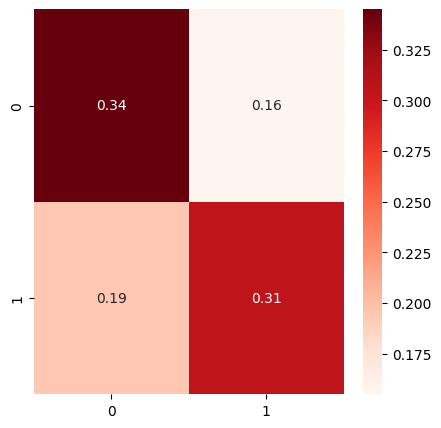

In [49]:
report(y_test, cb_best.predict(x_test))

### XGBoost

In [50]:
model = XGBClassifier()

In [51]:
model.fit(
    x_train,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [52]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [53]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-24 10:45:15,876] A new study created in memory with name: no-name-fb0b86b4-055a-4c80-ae2a-83b717da6dc8


[10:45:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:16,256] Trial 0 finished with value: 0.6103286384976526 and parameters: {'learning_rate': 0.00761483349684227, 'max_depth': 196, 'n_estimators': 100, 'subsample': 0.24924662983347162, 'colsample_bylevel': 0.46841762456950725, 'gamma': 1.405190987604389}. Best is trial 0 with value: 0.6103286384976526.


[10:45:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:18,222] Trial 1 finished with value: 0.5985037406483791 and parameters: {'learning_rate': 0.008624862521296796, 'max_depth': 456, 'n_estimators': 900, 'subsample': 0.06591625602220283, 'colsample_bylevel': 0.8894292446437968, 'gamma': 2.4472636138463826}. Best is trial 0 with value: 0.6103286384976526.


[10:45:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:18,882] Trial 2 finished with value: 0.5861182519280205 and parameters: {'learning_rate': 0.014781759885745194, 'max_depth': 168, 'n_estimators': 300, 'subsample': 0.21572979087841193, 'colsample_bylevel': 0.06559138886196564, 'gamma': 1.815028335753922}. Best is trial 0 with value: 0.6103286384976526.


[10:45:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:23,571] Trial 3 finished with value: 0.6161369193154035 and parameters: {'learning_rate': 0.07958348643321933, 'max_depth': 153, 'n_estimators': 900, 'subsample': 0.926295337580813, 'colsample_bylevel': 0.2850723349356546, 'gamma': 0.6611162168025484}. Best is trial 3 with value: 0.6161369193154035.


[10:45:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:25,741] Trial 4 finished with value: 0.6146572104018914 and parameters: {'learning_rate': 0.0013912677217501044, 'max_depth': 306, 'n_estimators': 200, 'subsample': 0.8044192093190604, 'colsample_bylevel': 0.7054587383021872, 'gamma': 1.4253705232947327}. Best is trial 3 with value: 0.6161369193154035.


[10:45:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:29,303] Trial 5 finished with value: 0.6124401913875598 and parameters: {'learning_rate': 0.0040049157835499675, 'max_depth': 127, 'n_estimators': 700, 'subsample': 0.5998538875367568, 'colsample_bylevel': 0.26029439636529905, 'gamma': 0.11073448829812736}. Best is trial 3 with value: 0.6161369193154035.


[10:45:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:30,440] Trial 6 finished with value: 0.5790754257907542 and parameters: {'learning_rate': 0.08367795260801539, 'max_depth': 122, 'n_estimators': 700, 'subsample': 0.06909640404804474, 'colsample_bylevel': 0.42604904215633205, 'gamma': 2.2118843829878903}. Best is trial 3 with value: 0.6161369193154035.


[10:45:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:32,930] Trial 7 finished with value: 0.6183574879227053 and parameters: {'learning_rate': 0.0041813565815787945, 'max_depth': 219, 'n_estimators': 700, 'subsample': 0.24386574501311836, 'colsample_bylevel': 0.45588401667103395, 'gamma': 2.563286620467919}. Best is trial 7 with value: 0.6183574879227053.


[10:45:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:35,223] Trial 8 finished with value: 0.6038647342995169 and parameters: {'learning_rate': 0.025445195610632007, 'max_depth': 205, 'n_estimators': 500, 'subsample': 0.2892819131444966, 'colsample_bylevel': 0.6588955766542911, 'gamma': 1.8107481237630303}. Best is trial 7 with value: 0.6183574879227053.


[10:45:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:41,061] Trial 9 finished with value: 0.6 and parameters: {'learning_rate': 0.01687929305406392, 'max_depth': 356, 'n_estimators': 500, 'subsample': 0.6779712658604095, 'colsample_bylevel': 0.9443866402954464, 'gamma': 2.076901001097967}. Best is trial 7 with value: 0.6183574879227053.


[10:45:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:47,767] Trial 10 finished with value: 0.6214953271028036 and parameters: {'learning_rate': 0.0010425420694098893, 'max_depth': 260, 'n_estimators': 1000, 'subsample': 0.4409797956672215, 'colsample_bylevel': 0.6418517057632395, 'gamma': 2.966708735675071}. Best is trial 10 with value: 0.6214953271028036.


[10:45:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:45:54,058] Trial 11 finished with value: 0.6376146788990824 and parameters: {'learning_rate': 0.0010561563762271884, 'max_depth': 262, 'n_estimators': 1000, 'subsample': 0.40742891624668953, 'colsample_bylevel': 0.651412398483927, 'gamma': 2.9290517343365594}. Best is trial 11 with value: 0.6376146788990824.


[10:45:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:01,304] Trial 12 finished with value: 0.6218097447795824 and parameters: {'learning_rate': 0.0010194639666810488, 'max_depth': 281, 'n_estimators': 1000, 'subsample': 0.45850166917949575, 'colsample_bylevel': 0.6922544191774429, 'gamma': 2.9233055767354728}. Best is trial 11 with value: 0.6376146788990824.


[10:46:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:09,857] Trial 13 finished with value: 0.6084905660377359 and parameters: {'learning_rate': 0.002277445318029595, 'max_depth': 349, 'n_estimators': 1000, 'subsample': 0.4824671823590339, 'colsample_bylevel': 0.8054728978461034, 'gamma': 2.9912276625789183}. Best is trial 11 with value: 0.6376146788990824.


[10:46:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:15,719] Trial 14 finished with value: 0.6298850574712644 and parameters: {'learning_rate': 0.0016369092578281887, 'max_depth': 433, 'n_estimators': 800, 'subsample': 0.41463116175735326, 'colsample_bylevel': 0.7755718356816542, 'gamma': 2.641352835431302}. Best is trial 11 with value: 0.6376146788990824.


[10:46:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:21,066] Trial 15 finished with value: 0.6214953271028036 and parameters: {'learning_rate': 0.0022760443820179052, 'max_depth': 494, 'n_estimators': 800, 'subsample': 0.35954379361918076, 'colsample_bylevel': 0.8159316605722229, 'gamma': 2.5550595430517045}. Best is trial 11 with value: 0.6376146788990824.


[10:46:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:27,333] Trial 16 finished with value: 0.6189376443418013 and parameters: {'learning_rate': 0.002046156491319336, 'max_depth': 405, 'n_estimators': 800, 'subsample': 0.6164832111728634, 'colsample_bylevel': 0.5543332956510785, 'gamma': 1.1515661757302924}. Best is trial 11 with value: 0.6376146788990824.


[10:46:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:34,274] Trial 17 finished with value: 0.6226415094339622 and parameters: {'learning_rate': 0.004099185704589549, 'max_depth': 422, 'n_estimators': 600, 'subsample': 0.740064994516404, 'colsample_bylevel': 0.7746084465715283, 'gamma': 2.6421413993545144}. Best is trial 11 with value: 0.6376146788990824.


[10:46:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:39,097] Trial 18 finished with value: 0.6211764705882353 and parameters: {'learning_rate': 0.0020188504511236584, 'max_depth': 333, 'n_estimators': 900, 'subsample': 0.3604654142195311, 'colsample_bylevel': 0.5757893997909056, 'gamma': 2.139832331787596}. Best is trial 11 with value: 0.6376146788990824.


[10:46:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:40,757] Trial 19 finished with value: 0.6157407407407407 and parameters: {'learning_rate': 0.004847834331404248, 'max_depth': 395, 'n_estimators': 400, 'subsample': 0.16157307985462266, 'colsample_bylevel': 0.9873525142915361, 'gamma': 0.8780566871306692}. Best is trial 11 with value: 0.6376146788990824.


[10:46:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:44,935] Trial 20 finished with value: 0.6211764705882353 and parameters: {'learning_rate': 0.04124745680095039, 'max_depth': 265, 'n_estimators': 800, 'subsample': 0.5548316731298999, 'colsample_bylevel': 0.34475193734499504, 'gamma': 2.735908701925933}. Best is trial 11 with value: 0.6376146788990824.


[10:46:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:46:51,812] Trial 21 finished with value: 0.6132075471698114 and parameters: {'learning_rate': 0.0036009571837442096, 'max_depth': 440, 'n_estimators': 600, 'subsample': 0.7251996168288559, 'colsample_bylevel': 0.7824792981066049, 'gamma': 2.3760627428290193}. Best is trial 11 with value: 0.6376146788990824.


[10:46:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:47:01,495] Trial 22 finished with value: 0.6407322654462242 and parameters: {'learning_rate': 0.0015660622565610233, 'max_depth': 396, 'n_estimators': 600, 'subsample': 0.9620223850628067, 'colsample_bylevel': 0.8665550915124219, 'gamma': 2.6447225844834135}. Best is trial 22 with value: 0.6407322654462242.


[10:47:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:47:14,973] Trial 23 finished with value: 0.6423690205011389 and parameters: {'learning_rate': 0.0015470461547739702, 'max_depth': 487, 'n_estimators': 800, 'subsample': 0.9840394677930457, 'colsample_bylevel': 0.8905626372019667, 'gamma': 1.9705119735648977}. Best is trial 23 with value: 0.6423690205011389.


[10:47:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:47:30,088] Trial 24 finished with value: 0.6272727272727273 and parameters: {'learning_rate': 0.0013600255344329228, 'max_depth': 379, 'n_estimators': 900, 'subsample': 0.9979465571996482, 'colsample_bylevel': 0.870049856053676, 'gamma': 1.859338413791543}. Best is trial 23 with value: 0.6423690205011389.


[10:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:47:39,072] Trial 25 finished with value: 0.6070588235294118 and parameters: {'learning_rate': 0.002866217480612285, 'max_depth': 500, 'n_estimators': 600, 'subsample': 0.8483373241019714, 'colsample_bylevel': 0.9276698212084229, 'gamma': 2.2265659255993913}. Best is trial 23 with value: 0.6423690205011389.


[10:47:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:47:50,516] Trial 26 finished with value: 0.6352941176470588 and parameters: {'learning_rate': 0.006171303029561556, 'max_depth': 458, 'n_estimators': 700, 'subsample': 0.9271682718146929, 'colsample_bylevel': 0.9991706279996335, 'gamma': 2.817563322984342}. Best is trial 23 with value: 0.6423690205011389.


[10:47:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:47:56,147] Trial 27 finished with value: 0.6080760095011876 and parameters: {'learning_rate': 0.001018050183437118, 'max_depth': 472, 'n_estimators': 400, 'subsample': 0.8535027149982533, 'colsample_bylevel': 0.8613919593369233, 'gamma': 1.9499780089943468}. Best is trial 23 with value: 0.6423690205011389.


[10:47:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:48:08,104] Trial 28 finished with value: 0.616822429906542 and parameters: {'learning_rate': 0.00282005094581844, 'max_depth': 306, 'n_estimators': 1000, 'subsample': 0.9795055999253477, 'colsample_bylevel': 0.6112932739692178, 'gamma': 1.6777586469558425}. Best is trial 23 with value: 0.6423690205011389.


[10:48:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:48:17,300] Trial 29 finished with value: 0.6135831381733021 and parameters: {'learning_rate': 0.0015093419354172055, 'max_depth': 240, 'n_estimators': 900, 'subsample': 0.9137280783762516, 'colsample_bylevel': 0.5193751281646727, 'gamma': 2.3628205300068528}. Best is trial 23 with value: 0.6423690205011389.


In [54]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0015470461547739702, 'max_depth': 487, 'n_estimators': 800, 'subsample': 0.9840394677930457, 'colsample_bylevel': 0.8905626372019667, 'gamma': 1.9705119735648977}
Best f1 score: 0.6423690205011389


In [55]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train, y_train)

[10:48:17] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8905626372019667, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.9705119735648977, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0015470461547739702, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=487, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [56]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

[10:48:31] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:48:41] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:48:52] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:49:02] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[10:49:12] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([10.57726812, 10.36462927, 10.53662086, 10.07088733, 10.10944676]),
 'score_time': array([0.02308083, 0.02141881, 0.02215266, 0.02050209, 0.02118278]),
 'test_accuracy': array([0.8057554 , 0.82494005, 0.79086538, 0.80769231, 0.82451923]),
 'test_precision_macro': array([0.77984111, 0.80035971, 0.76244893, 0.78116176, 0.80013246]),
 'test_recall_macro': array([0.79384776, 0.80370787, 0.76144958, 0.79285714, 0.80346639]),
 'test_f1_macro': array([0.78554967, 0.80197756, 0.76194329, 0.78616223, 0.8017431 ]),
 'test_roc_auc': array([0.87192388, 0.89124974, 0.8644958 , 0.8634979 , 0.87607668])}

In [57]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       216
           1       0.63      0.65      0.64       216

    accuracy                           0.64       432
   macro avg       0.64      0.64      0.64       432
weighted avg       0.64      0.64      0.64       432

F2-score:  0.6485740570377185


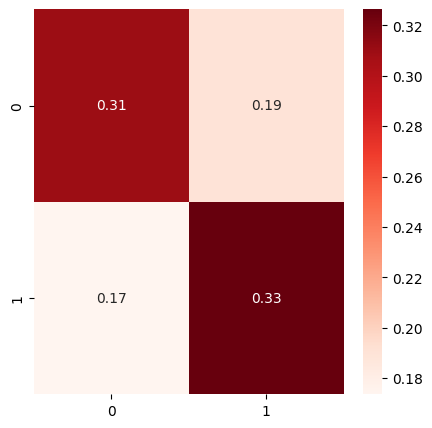

In [58]:
report(y_test, xgb_best.predict(x_test))

### LightGBM

In [59]:
model = LGBMClassifier()

In [60]:
model.fit(
    x_train,
    y_train,
    )

LGBMClassifier()

In [61]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [62]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-24 10:49:23,443] A new study created in memory with name: no-name-6ef527b3-1ad2-4b33-b7d4-87571ae19cfc


[10:49:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:49:29,448] Trial 0 finished with value: 0.6113744075829385 and parameters: {'learning_rate': 0.006268423036350702, 'max_depth': 256, 'n_estimators': 500, 'subsample': 0.7175128635302325, 'colsample_bylevel': 0.8711190600106626, 'gamma': 2.3073294329865806}. Best is trial 0 with value: 0.6113744075829385.


[10:49:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:49:33,774] Trial 1 finished with value: 0.6161137440758294 and parameters: {'learning_rate': 0.0026839110191505125, 'max_depth': 120, 'n_estimators': 900, 'subsample': 0.26162089070421846, 'colsample_bylevel': 0.7251424974502074, 'gamma': 1.3031303431715495}. Best is trial 1 with value: 0.6161137440758294.


[10:49:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:49:44,162] Trial 2 finished with value: 0.6128266033254156 and parameters: {'learning_rate': 0.034862472204620576, 'max_depth': 254, 'n_estimators': 700, 'subsample': 0.9749937631086757, 'colsample_bylevel': 0.9121870437664211, 'gamma': 1.6506171012400512}. Best is trial 1 with value: 0.6161137440758294.


[10:49:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:49:49,338] Trial 3 finished with value: 0.5790754257907542 and parameters: {'learning_rate': 0.09533340381719992, 'max_depth': 148, 'n_estimators': 700, 'subsample': 0.746211679751056, 'colsample_bylevel': 0.5405473970552034, 'gamma': 1.458200629201207}. Best is trial 1 with value: 0.6161137440758294.


[10:49:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:49:54,732] Trial 4 finished with value: 0.6247086247086246 and parameters: {'learning_rate': 0.0056526408500878365, 'max_depth': 378, 'n_estimators': 400, 'subsample': 0.9488706268243768, 'colsample_bylevel': 0.7375038939525801, 'gamma': 0.5824512921212458}. Best is trial 4 with value: 0.6247086247086246.


[10:49:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:02,293] Trial 5 finished with value: 0.6190476190476191 and parameters: {'learning_rate': 0.03184656323629896, 'max_depth': 454, 'n_estimators': 700, 'subsample': 0.7455145839049245, 'colsample_bylevel': 0.8798858050617878, 'gamma': 1.2458366838308383}. Best is trial 4 with value: 0.6247086247086246.


[10:50:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:13,298] Trial 6 finished with value: 0.5956416464891041 and parameters: {'learning_rate': 0.0076397751400314965, 'max_depth': 200, 'n_estimators': 1000, 'subsample': 0.9421485170558623, 'colsample_bylevel': 0.5951721423032353, 'gamma': 2.2006144119041666}. Best is trial 4 with value: 0.6247086247086246.


[10:50:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:16,491] Trial 7 finished with value: 0.6080760095011876 and parameters: {'learning_rate': 0.05247127403421375, 'max_depth': 274, 'n_estimators': 500, 'subsample': 0.5383247008972127, 'colsample_bylevel': 0.7246378875659537, 'gamma': 0.2285832442389381}. Best is trial 4 with value: 0.6247086247086246.


[10:50:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:18,495] Trial 8 finished with value: 0.5990338164251209 and parameters: {'learning_rate': 0.024886892149645116, 'max_depth': 131, 'n_estimators': 200, 'subsample': 0.5935692626910667, 'colsample_bylevel': 0.8242666315613666, 'gamma': 2.8865651380295896}. Best is trial 4 with value: 0.6247086247086246.


[10:50:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:21,231] Trial 9 finished with value: 0.6161137440758294 and parameters: {'learning_rate': 0.01122379762717561, 'max_depth': 409, 'n_estimators': 300, 'subsample': 0.5597427780231162, 'colsample_bylevel': 0.7809013002350484, 'gamma': 2.5824475646404603}. Best is trial 4 with value: 0.6247086247086246.


[10:50:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:21,407] Trial 10 finished with value: 0.5069637883008357 and parameters: {'learning_rate': 0.0010041679272945125, 'max_depth': 355, 'n_estimators': 100, 'subsample': 0.051980856146032206, 'colsample_bylevel': 0.21859805066953486, 'gamma': 0.31113659023441786}. Best is trial 4 with value: 0.6247086247086246.


[10:50:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:24,191] Trial 11 finished with value: 0.5899280575539567 and parameters: {'learning_rate': 0.015775912333988278, 'max_depth': 491, 'n_estimators': 400, 'subsample': 0.8234276480548733, 'colsample_bylevel': 0.34707428660061607, 'gamma': 0.8669556218386492}. Best is trial 4 with value: 0.6247086247086246.


[10:50:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:34,710] Trial 12 finished with value: 0.6203703703703703 and parameters: {'learning_rate': 0.00341015270061364, 'max_depth': 456, 'n_estimators': 700, 'subsample': 0.8236388275107318, 'colsample_bylevel': 0.9970903599763072, 'gamma': 0.8437989743878136}. Best is trial 4 with value: 0.6247086247086246.


[10:50:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:49,018] Trial 13 finished with value: 0.6272727272727273 and parameters: {'learning_rate': 0.0034247848753111974, 'max_depth': 352, 'n_estimators': 800, 'subsample': 0.9984102999479563, 'colsample_bylevel': 0.9959176572305858, 'gamma': 0.7108050134104635}. Best is trial 13 with value: 0.6272727272727273.


[10:50:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:57,013] Trial 14 finished with value: 0.6037735849056604 and parameters: {'learning_rate': 0.0028987684692630606, 'max_depth': 345, 'n_estimators': 900, 'subsample': 0.9989882475360052, 'colsample_bylevel': 0.37443038891566666, 'gamma': 0.6562351896024148}. Best is trial 13 with value: 0.6272727272727273.


[10:50:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:58,771] Trial 15 finished with value: 0.6289592760180994 and parameters: {'learning_rate': 0.001144518715821154, 'max_depth': 350, 'n_estimators': 300, 'subsample': 0.3794835529236085, 'colsample_bylevel': 0.6633174148794104, 'gamma': 0.5827708475884769}. Best is trial 15 with value: 0.6289592760180994.


[10:50:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:50:59,076] Trial 16 finished with value: 0.5483870967741936 and parameters: {'learning_rate': 0.0013342807885732087, 'max_depth': 313, 'n_estimators': 100, 'subsample': 0.35726200548600623, 'colsample_bylevel': 0.09669114837300596, 'gamma': 1.7849404727332883}. Best is trial 15 with value: 0.6289592760180994.


[10:50:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:00,864] Trial 17 finished with value: 0.6351351351351351 and parameters: {'learning_rate': 0.0015735147029554645, 'max_depth': 413, 'n_estimators': 300, 'subsample': 0.39743760215066626, 'colsample_bylevel': 0.6205582359596646, 'gamma': 0.10298155323882252}. Best is trial 17 with value: 0.6351351351351351.


[10:51:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:02,557] Trial 18 finished with value: 0.6230248306997743 and parameters: {'learning_rate': 0.0018361988226454791, 'max_depth': 419, 'n_estimators': 300, 'subsample': 0.36909911775881354, 'colsample_bylevel': 0.6191223369490498, 'gamma': 0.1481483822943935}. Best is trial 17 with value: 0.6351351351351351.


[10:51:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:03,468] Trial 19 finished with value: 0.627906976744186 and parameters: {'learning_rate': 0.0017175804651961468, 'max_depth': 315, 'n_estimators': 300, 'subsample': 0.19044014278740057, 'colsample_bylevel': 0.43130195229436297, 'gamma': 0.4108541456084299}. Best is trial 17 with value: 0.6351351351351351.


[10:51:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:04,772] Trial 20 finished with value: 0.6100917431192661 and parameters: {'learning_rate': 0.0010058509403943919, 'max_depth': 403, 'n_estimators': 200, 'subsample': 0.42389793820734517, 'colsample_bylevel': 0.6597690943137637, 'gamma': 1.0928124046227246}. Best is trial 17 with value: 0.6351351351351351.


[10:51:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:05,685] Trial 21 finished with value: 0.6189376443418013 and parameters: {'learning_rate': 0.0018180393632830007, 'max_depth': 305, 'n_estimators': 300, 'subsample': 0.1983190230821988, 'colsample_bylevel': 0.419987195956089, 'gamma': 0.45825887860647085}. Best is trial 17 with value: 0.6351351351351351.


[10:51:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:06,799] Trial 22 finished with value: 0.6420323325635103 and parameters: {'learning_rate': 0.0018257953019455118, 'max_depth': 300, 'n_estimators': 400, 'subsample': 0.16104960139766356, 'colsample_bylevel': 0.4588868462859286, 'gamma': 0.3879753058159355}. Best is trial 22 with value: 0.6420323325635103.


[10:51:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:07,561] Trial 23 finished with value: 0.5792079207920793 and parameters: {'learning_rate': 0.004335391687609849, 'max_depth': 235, 'n_estimators': 400, 'subsample': 0.06694502143192038, 'colsample_bylevel': 0.5045073201947803, 'gamma': 0.12446627392007335}. Best is trial 22 with value: 0.6420323325635103.


[10:51:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:08,446] Trial 24 finished with value: 0.6208530805687204 and parameters: {'learning_rate': 0.002292977820428098, 'max_depth': 209, 'n_estimators': 200, 'subsample': 0.4620389855588305, 'colsample_bylevel': 0.2762004057001969, 'gamma': 0.9912705641516788}. Best is trial 22 with value: 0.6420323325635103.


[10:51:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:10,933] Trial 25 finished with value: 0.6347031963470319 and parameters: {'learning_rate': 0.0013577541439803707, 'max_depth': 380, 'n_estimators': 600, 'subsample': 0.288255850800536, 'colsample_bylevel': 0.49514299247935384, 'gamma': 0.444744599751207}. Best is trial 22 with value: 0.6420323325635103.


[10:51:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:13,391] Trial 26 finished with value: 0.640552995391705 and parameters: {'learning_rate': 0.0015145163390586313, 'max_depth': 440, 'n_estimators': 600, 'subsample': 0.2736273086037503, 'colsample_bylevel': 0.5175954390816165, 'gamma': 0.3871056050489751}. Best is trial 22 with value: 0.6420323325635103.


[10:51:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:15,250] Trial 27 finished with value: 0.625 and parameters: {'learning_rate': 0.0021444594776352673, 'max_depth': 496, 'n_estimators': 600, 'subsample': 0.17026066520275965, 'colsample_bylevel': 0.5636867657294959, 'gamma': 1.8914848567144111}. Best is trial 22 with value: 0.6420323325635103.


[10:51:15] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:17,402] Trial 28 finished with value: 0.6124401913875598 and parameters: {'learning_rate': 0.004670642874633596, 'max_depth': 441, 'n_estimators': 500, 'subsample': 0.3026099010599617, 'colsample_bylevel': 0.46947984334375437, 'gamma': 0.10189266803324726}. Best is trial 22 with value: 0.6420323325635103.


[10:51:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 10:51:18,678] Trial 29 finished with value: 0.5822784810126583 and parameters: {'learning_rate': 0.007638605628669083, 'max_depth': 474, 'n_estimators': 600, 'subsample': 0.11877278217693218, 'colsample_bylevel': 0.30378536054538036, 'gamma': 0.7860612411829973}. Best is trial 22 with value: 0.6420323325635103.


In [63]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.0018257953019455118, 'max_depth': 300, 'n_estimators': 400, 'subsample': 0.16104960139766356, 'colsample_bylevel': 0.4588868462859286, 'gamma': 0.3879753058159355}
Best f1 score: 0.6420323325635103


In [64]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.0018257953019455118, max_depth=300,
               n_estimators=400, random_seed=42, subsample=0.16104960139766356)

In [65]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.88140869, 0.92774057, 0.8880837 , 0.88172817, 0.87395835]),
 'score_time': array([0.01238847, 0.01215124, 0.0120039 , 0.01226377, 0.01192403]),
 'test_accuracy': array([0.77458034, 0.78657074, 0.76682692, 0.78365385, 0.79807692]),
 'test_precision_macro': array([0.74959788, 0.77836394, 0.74280662, 0.76282051, 0.78854167]),
 'test_recall_macro': array([0.71844369, 0.71263345, 0.70010504, 0.72394958, 0.73277311]),
 'test_f1_macro': array([0.72901112, 0.72915161, 0.71237749, 0.73648649, 0.74896552]),
 'test_roc_auc': array([0.8770464 , 0.88588549, 0.85909926, 0.85895483, 0.86496849])}

In [66]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.56      0.88      0.68       216
           1       0.72      0.31      0.44       216

    accuracy                           0.59       432
   macro avg       0.64      0.59      0.56       432
weighted avg       0.64      0.59      0.56       432

F2-score:  0.3545359749739312


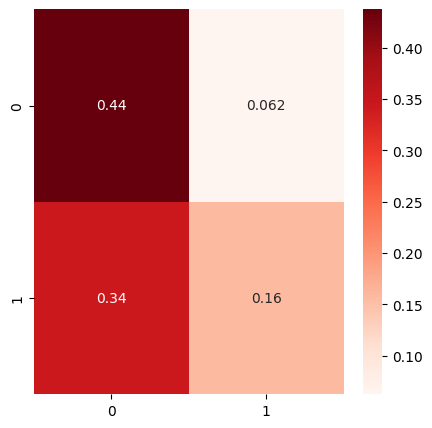

In [67]:
report(y_test, lgbm_best.predict(x_test))

# Результаты

In [68]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [69]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [70]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [71]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.8 +- 0.02 , 'AUC': 0.87 +- 0.01 ,'Precision': 0.78 +- 0.02 ,'Recall': 0.76 +- 0.02 ,'F1-score': 0.77 +- 0.02 ,'F2-score': 0.76 +- 0.02
'Accuracy': 0.82 +- 0.02 , 'AUC': 0.88 +- 0.01 ,'Precision': 0.8 +- 0.02 ,'Recall': 0.81 +- 0.02 ,'F1-score': 0.8 +- 0.02 ,'F2-score': 0.81 +- 0.02
'Accuracy': 0.81 +- 0.01 , 'AUC': 0.87 +- 0.01 ,'Precision': 0.78 +- 0.01 ,'Recall': 0.79 +- 0.02 ,'F1-score': 0.79 +- 0.01 ,'F2-score': 0.79 +- 0.02
'Accuracy': 0.78 +- 0.01 , 'AUC': 0.87 +- 0.01 ,'Precision': 0.76 +- 0.02 ,'Recall': 0.72 +- 0.01 ,'F1-score': 0.73 +- 0.01 ,'F2-score': 0.73 +- 0.01
'Accuracy': 0.82 +- 0.02 , 'AUC': 0.89 +- 0.01 ,'Precision': 0.8 +- 0.02 ,'Recall': 0.8 +- 0.02 ,'F1-score': 0.8 +- 0.02 ,'F2-score': 0.8 +- 0.02


In [72]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_val_imp, y_val))
  else: print(test_results(model, x_val, y_val))

{'Accuracy': 0.79, 'AUC': 0.74, 'Precision': 0.69, 'Recall': 0.61, 'F1-score': 0.65, 'F2-score': 0.63}
{'Accuracy': 0.81, 'AUC': 0.79, 'Precision': 0.67, 'Recall': 0.75, 'F1-score': 0.71, 'F2-score': 0.74}
{'Accuracy': 0.81, 'AUC': 0.79, 'Precision': 0.67, 'Recall': 0.75, 'F1-score': 0.71, 'F2-score': 0.74}
{'Accuracy': 0.79, 'AUC': 0.73, 'Precision': 0.69, 'Recall': 0.58, 'F1-score': 0.63, 'F2-score': 0.6}
{'Accuracy': 0.82, 'AUC': 0.8, 'Precision': 0.69, 'Recall': 0.76, 'F1-score': 0.72, 'F2-score': 0.75}


In [73]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test, y_test))

{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.67, 'Recall': 0.35, 'F1-score': 0.46, 'F2-score': 0.39}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.61, 'Recall': 0.66, 'F1-score': 0.64, 'F2-score': 0.65}
{'Accuracy': 0.64, 'AUC': 0.64, 'Precision': 0.63, 'Recall': 0.65, 'F1-score': 0.64, 'F2-score': 0.65}
{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.72, 'Recall': 0.31, 'F1-score': 0.44, 'F2-score': 0.35}
{'Accuracy': 0.65, 'AUC': 0.65, 'Precision': 0.66, 'Recall': 0.61, 'F1-score': 0.64, 'F2-score': 0.62}


In [74]:
from catboost import CatBoostClassifier, CatBoostRegressor
import shap
shap.initjs()

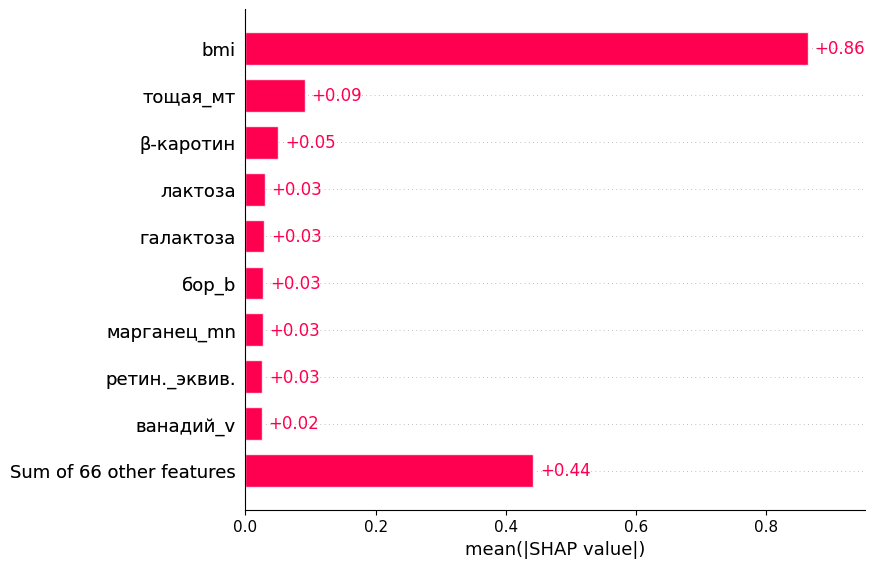

In [75]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
#shap.plots.force(shap_values)
shap.plots.bar(shap_values)

In [89]:
len(best_models)

5

In [91]:
file_names = ["RFClassifier.txt","XGBRFClassifier.txt","XGBoostClassifier.txt","LightGBMClassifier.txt","CatBoostClassifier.txt"]
for i in range(len(best_models)):
    file = open(file_names[i], "w")
    file.write(str(best_models[i].feature_importances_))
    file.close()